In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import os
import numpy as np
from torchinfo import summary
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
from Convs_Unet import UNet

In [2]:
from torch.utils.data import random_split

In [3]:
from tqdm.notebook import trange, tqdm

In [4]:
##Final ensemble model 

In [5]:
class Im_Seg(torch.nn.Module):
    def __init__(self ,device, loc = "../models/" , trainable = set()):
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()) , requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(()) , requires_grad=True)
        self.c = torch.nn.Parameter(torch.randn(()) , requires_grad=True)
        self.d = torch.nn.Parameter(torch.randn(()) , requires_grad=True)
        self.mod1 = UNet(n_channels = 3 , n_classes = 1) 
        self.mod2 = UNet(n_channels = 3 , n_classes = 1) 
        self.mod3 = UNet(n_channels = 3 , n_classes = 1) 
        self.mod1.to(device = device)
        self.mod2.to(device = device)
        self.mod3.to(device = device)
        self.mod1.load_state_dict(torch.load(loc + "model1.pth", map_location=device))
        self.mod2.load_state_dict(torch.load(loc + "model2.pth", map_location=device))
        self.mod3.load_state_dict(torch.load(loc + "model3.pth", map_location=device))
        for k in self.mod1.named_parameters():
            k[1].requires_grad = True if k[0].split(".")[0] in trainable else False
        for k in self.mod2.named_parameters():
            k[1].requires_grad = True if k[0].split(".")[0] in trainable else False  
        for k in self.mod3.named_parameters():
            k[1].requires_grad = True if k[0].split(".")[0] in trainable else False  
            
    def check_state(self , mod):
        dic = {1 : self.mod1 , 2 : self.mod2 , 3 : self.mod3 }
        return dic[mod].named_parameters()
    
    def forward(self , inp1 , inp2 ,inp3):
        out1 = torch.sigmoid(self.mod1(inp1))
        out2 = torch.sigmoid(self.mod2(inp2))
        out3 = torch.sigmoid(self.mod3(inp3))
        return torch.sigmoid(self.a*out1 + self.b*out2 + self.c*out3 + self.d)
    
        

In [6]:
class Data_from_disk_full_tag(torch.utils.data.Dataset) :
    def __init__(self, dir_ = "../Data/Full_Aug/"): #tag indicates the type of input image to be trained on 
        super().__init__() 
        self.dir_ = dir_
        self.inp_dir_0 = sorted([x for x in os.listdir(dir_ + "Im_inp/") if x.split("_")[2] == str(0)])
        self.inp_dir_1 = sorted([x for x in os.listdir(dir_ + "Im_inp/") if x.split("_")[2] == str(1)])
        self.inp_dir_2 = sorted([x for x in os.listdir(dir_ + "Im_inp/") if x.split("_")[2] == str(2)])
        self.out_dir = sorted(os.listdir(dir_ + "Im_out/"))
        print(len(self.inp_dir_0) ,len(self.inp_dir_1) ,len(self.inp_dir_2) ,len(self.out_dir))
        
    def __getitem__(self , idx):
        #print(self.inp_dir[idx] , self.out_dir[idx])
        #assert self.inp_dir[idx] == self.out_dir[idx] , f"names dont match . given names are {self.inp_dir[idx]} and {self.out_dir[idx]}"
        #assert self.inp_dir[idx].split("_")[2] == str(self.tag) , f"tags are different , required : {self.tag} , found : {self.inp_dir[idx].split('_')[2]}"
        #print(self.inp_dir_0[idx] , self.inp_dir_1[idx] , self.inp_dir_2[idx] , self.out_dir[idx])
        ch0 = tuple([ss for i , ss in enumerate(self.inp_dir_0[idx].split("_")) if i != 2])
        ch1 = tuple([ss for i , ss in enumerate(self.inp_dir_1[idx].split("_")) if i != 2])
        ch2 = tuple([ss for i , ss in enumerate(self.inp_dir_2[idx].split("_")) if i != 2])
        ch3 = tuple([ss for i , ss in enumerate(self.out_dir[idx].split("_")) if i != 2])
        #print(ch0 , ch1 ,ch2 ,ch3)
        assert ch0 == ch1 and ch1 == ch2 and ch2 == ch3 , f"Names dont match {self.inp_dir_0[idx] , self.inp_dir_1[idx] , self.inp_dir_2[idx] , self.out_dir[idx]}"
        x1_0 = np.array(Image.open(self.dir_ + "Im_inp/" + self.inp_dir_0[idx]))
        x1_1 = np.array(Image.open(self.dir_ + "Im_inp/" + self.inp_dir_1[idx]))
        x1_2 = np.array(Image.open(self.dir_ + "Im_inp/" + self.inp_dir_2[idx]))
        x2 = np.array(Image.open(self.dir_ + "Im_out/" + self.out_dir[idx]))[:,:,0:1]
        x1_0 = np.transpose(x1_0 ,(2, 0, 1))
        x1_1 = np.transpose(x1_1 ,(2, 0, 1))
        x1_2 = np.transpose(x1_2 ,(2, 0, 1))
        x2 = np.transpose(x2 ,(2, 0, 1))
        x1_0 = x1_0/255
        x1_1 = x1_1/255
        x1_2 = x1_2/255
        x2 = x2/255
        #assert self.inp_dir_0[idx].split("_")[2] == str(0) , f"tags are different , required : {self.tag} , found : {self.inp_dir[idx].split('_')[2]}"
        #if return_names :
        #return (torch.from_numpy(x1) , torch.from_numpy(x2)) , (self.inp_dir[idx] ,self.out_dir[idx] )
        return ((torch.from_numpy(x1_0) , torch.from_numpy(x1_1) , torch.from_numpy(x1_2)) , torch.from_numpy(x2))
    
    def __len__(self):
        return (len(self.inp_dir_0))  

In [7]:
# test the iterator first

In [8]:
#dd = Data_from_disk_full_tag()

In [9]:
#for i in range(len(dd) - 2,len(dd)):
#    dd[i]
#    break

In [10]:
#after thorough testing

In [11]:
g1 = torch.Generator().manual_seed(42)
train_ds , val_ds , test_ds = random_split(Data_from_disk_full_tag() , [359 , 102 ,51] , generator = g1)

512 512 512 512


In [12]:
len(train_ds) , len(val_ds) , len(test_ds)

(359, 102, 51)

In [13]:
batch = 4
EPOCHS = 30
lr = 0.005

In [14]:
train_loader = DataLoader(train_ds , batch , shuffle = True)
val_loader = DataLoader(val_ds , batch)
test_loader = DataLoader(test_ds , batch)

In [15]:
def evaluate(model , val_loader ,loss_func ):
    curr_val_loss = 0
    with torch.no_grad() :
        for i ,mm in enumerate(val_loader):
            x = mm[0]
            y = mm[1]
            for j in range(3):
                x[j] = x[j].to(device , dtype = torch.float32)
            y = y.to(device , dtype = torch.float32)
            loss = loss_func(model(*x), y)
            curr_val_loss = (curr_val_loss*(i) + loss)/(i+1)
    return curr_val_loss

In [16]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss*(self.min_delta + 1)):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False  

In [17]:
early_stopper = EarlyStopper(patience = 3 , min_delta = 0.05)
def fit(model , epochs , lr , train_loader , val_loader , opt_func , loss_func ):
    #Q = deque()
    history = []
    optimizer = opt_func(model.parameters() , lr)
    cur_val_loss = 0
    scheduler =  torch.optim.lr_scheduler.ExponentialLR(optimizer , gamma = 0.95 , verbose = True)
    for epoch in trange(epochs , total = epochs , desc="num_epochs") :
        iterator = tqdm(enumerate(train_loader) , total = len(train_loader) ,desc="num_batches") 
        for i ,mm in iterator:
            x = mm[0]
            y = mm[1]
            for j in range(3):
                x[j] = x[j].to(device , dtype = torch.float32)
            y = y.to(device , non_blocking = True , dtype = torch.float32)
            #scheduler.print_lr()
            #print(x.device , y.device)
            optimizer.zero_grad()
            #print("zero_grad")
            loss = loss_func(model(*x), y)
            #print("calc_loss")
            iterator.set_postfix(train_loss = loss.item())
            loss.backward()
            optimizer.step()
            
            #torch.cuda.empty_cache()
        scheduler.step()    
        val_err = evaluate(model , val_loader , loss_func)
        curr_train_loss = evaluate(model , train_loader , loss_func)
        print(f"train_loss : {curr_train_loss}  , val_loss : {val_err}")
        history.append((curr_train_loss , val_err ))
        #if len(Q) == 3 :
        #    Q.popleft()
        #Q.append(model.parameters())
        if early_stopper.early_stop(val_err) :
            #model.parameters() = Q[0]
            break
            
    return history        
            

In [21]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Im_Seg(device)

In [22]:
model.to(device=device)
model.load_state_dict(torch.load("final_model.pth", map_location=device))

<All keys matched successfully>

In [18]:
# for ss in model.parameters() :
#     print(ss , ss.is_cuda)
#     if not ss.is_cuda:
#         print(ss , ss.is_cuda)

In [19]:
# for ss in model.named_parameters():
#     #print(ss[0] ,"=>" , ss[1].device)
#     print(ss)
#     break

In [20]:
# for ss in model.check_state(3) :
#     print(ss[0] ," : ", ss[1].shape , " : " , ss[1].requires_grad)

In [25]:
summary(model)

Layer (type:depth-idx)                             Param #
Im_Seg                                             4
├─UNet: 1-1                                        --
│    └─DoubleConv: 2-1                             --
│    │    └─Sequential: 3-1                        (38,976)
│    └─DownConv: 2-2                               --
│    │    └─Sequential: 3-2                        (221,952)
│    └─DownConv: 2-3                               --
│    │    └─Sequential: 3-3                        (886,272)
│    └─DownConv: 2-4                               --
│    │    └─Sequential: 3-4                        (3,542,016)
│    └─DownConv: 2-5                               --
│    │    └─Sequential: 3-5                        (4,721,664)
│    └─UpConv: 2-6                                 --
│    │    └─Upsample: 3-6                          --
│    │    └─DoubleConv: 3-7                        (5,900,544)
│    └─UpConv: 2-7                                 --
│    │    └─Upsample: 3-8      

In [26]:
fit_dic1 = {"model" : model ,
           "epochs" : EPOCHS ,
           "lr" : lr ,
           "train_loader" : train_loader ,
           "val_loader" : val_loader ,
           "opt_func" : torch.optim.Adam  ,
           "loss_func" : torch.nn.functional.binary_cross_entropy}

In [27]:
history = fit(**fit_dic1)

Adjusting learning rate of group 0 to 5.0000e-03.


num_epochs:   0%|          | 0/30 [00:00<?, ?it/s]

num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7500e-03.
train_loss : 0.10280416160821915  , val_loss : 0.11249881237745285


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5125e-03.
train_loss : 0.10274264216423035  , val_loss : 0.11247757822275162


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2869e-03.
train_loss : 0.10260990262031555  , val_loss : 0.11252434551715851


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0725e-03.
train_loss : 0.10269676148891449  , val_loss : 0.1124635860323906


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8689e-03.
train_loss : 0.10237295925617218  , val_loss : 0.11251063644886017


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.6755e-03.
train_loss : 0.10255953669548035  , val_loss : 0.11247994005680084


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4917e-03.
train_loss : 0.10247880220413208  , val_loss : 0.11250320822000504


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.3171e-03.
train_loss : 0.10267385095357895  , val_loss : 0.11248303949832916


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1512e-03.
train_loss : 0.10281465202569962  , val_loss : 0.11247238516807556


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.9937e-03.
train_loss : 0.10248863697052002  , val_loss : 0.11248548328876495


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8440e-03.
train_loss : 0.1024387776851654  , val_loss : 0.11250495165586472


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7018e-03.
train_loss : 0.10255838930606842  , val_loss : 0.11258366703987122


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5667e-03.
train_loss : 0.10262639075517654  , val_loss : 0.11252739280462265


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.4384e-03.
train_loss : 0.10265414416790009  , val_loss : 0.11256499588489532


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.3165e-03.
train_loss : 0.10243101418018341  , val_loss : 0.11250470578670502


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2006e-03.
train_loss : 0.10241718590259552  , val_loss : 0.11249790340662003


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0906e-03.
train_loss : 0.10239648073911667  , val_loss : 0.11250539124011993


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.9861e-03.
train_loss : 0.10255758464336395  , val_loss : 0.11250752210617065


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8868e-03.
train_loss : 0.10283875465393066  , val_loss : 0.11249381303787231


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7924e-03.
train_loss : 0.10257741063833237  , val_loss : 0.11248842626810074


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.7028e-03.
train_loss : 0.10248956829309464  , val_loss : 0.11251043528318405


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6177e-03.
train_loss : 0.1027456521987915  , val_loss : 0.11250550299882889


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5368e-03.
train_loss : 0.10254435241222382  , val_loss : 0.11251631379127502


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4599e-03.
train_loss : 0.10281427204608917  , val_loss : 0.11248902231454849


num_batches:   0%|          | 0/90 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
#torch.save(model.state_dict(), "final_model.pth")  
#print("Saved model to final_model.pth")
#history = np.array([(x111[0].item() , x111[1].item()) for x111 in history])
#np.savetxt('history4.csv', history, delimiter=',')

In [28]:
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Im_Seg(device)

In [19]:
device

device(type='cpu')

In [20]:
#evaluate(model , test_loader ,torch.nn.functional.binary_cross_entropy )

In [ ]:
model.to(device=device)
model.load_state_dict(torch.load("final_model.pth", map_location=device))

In [46]:
for i in model.named_parameters() :
    print(i)

('a', Parameter containing:
tensor(3.4921, requires_grad=True))
('b', Parameter containing:
tensor(4.7248, requires_grad=True))
('c', Parameter containing:
tensor(1.4496, requires_grad=True))
('d', Parameter containing:
tensor(-4.6429, requires_grad=True))
('mod1.inc.double_conv.0.weight', Parameter containing:
tensor([[[[ 1.8891e-38,  1.7821e-38,  2.3253e-38],
          [ 1.5670e-38,  1.4314e-38,  1.0727e-38],
          [ 1.3786e-38,  1.4174e-38,  1.2988e-38]],

         [[ 6.2313e-38,  4.3693e-38,  3.2927e-38],
          [ 6.3985e-38,  5.7717e-38,  6.7191e-38],
          [ 6.8400e-38,  6.7746e-38,  4.9936e-38]],

         [[ 6.8120e-38,  6.2146e-38,  5.7528e-38],
          [ 4.6568e-38,  6.5558e-38,  5.5100e-38],
          [ 5.0219e-38,  4.6784e-38,  3.9735e-38]]],


        [[[ 4.0789e-39,  5.2598e-40,  3.2969e-39],
          [-4.7167e-40,  3.6139e-39, -3.0623e-39],
          [ 4.3252e-39,  4.1237e-39,  5.3400e-40]],

         [[ 1.1483e-38,  7.5231e-39,  9.1416e-39],
          [ 6.

('mod1.up3.conv.double_conv.4.weight', Parameter containing:
tensor([ 1.8844e-38,  4.0337e-38, -1.1288e-38,  1.7159e+01, -3.7411e-38,
         1.4803e+01,  6.3513e-38, -2.8675e-39,  1.8050e-38, -4.8812e-39,
         3.1555e-38,  7.6771e+00,  3.3497e+00, -2.6577e-38, -5.7026e-38,
        -7.1228e-39, -1.1449e-42, -3.8835e-38, -4.1672e-39,  1.2895e+01,
        -1.1099e-38,  2.2596e+01,  6.4048e-38,  5.4569e-38, -3.0516e-38,
         7.7063e-39,  2.9088e-38, -2.4458e-38, -1.7766e-38,  2.5600e-38,
         2.1241e-38,  7.5110e+00,  1.7304e+01,  1.3676e+01, -5.1431e-38,
         7.5618e-39, -2.5386e-38, -5.4859e-38,  1.0437e+01, -2.4458e-38,
        -6.3348e+00, -6.9252e-41, -1.9316e-38, -3.5698e-38, -9.5562e+00,
        -2.0762e-38,  6.3858e-38, -3.8789e-38, -4.6949e-38,  2.5172e-38,
         1.1417e+01, -5.8387e-39, -8.1804e-39,  1.6537e-38, -5.5199e-38,
         1.0540e-38,  7.0416e+00,  2.6574e-39, -8.3780e-40, -4.2923e-38,
         3.6921e-39,  1.5478e+01,  6.0350e-39,  5.0906e-38]))
(

('mod2.up3.conv.double_conv.0.bias', Parameter containing:
tensor([-2.7842e-35,  6.1001e-38,  6.3076e-38, -6.3752e-38,  1.8351e-38,
        -6.3113e-38, -5.0836e-38,  3.7186e-38,  1.4068e-04, -1.0358e-38,
         2.9739e-38,  2.4021e-38,  3.4622e-38, -1.2912e-38,  6.9390e-38,
         6.3129e-38,  6.2537e-38, -8.4817e-06,  1.2655e-04,  6.3161e-38,
        -6.3319e-38, -1.8582e-39,  6.3199e-38,  6.3505e-38,  1.2273e-27,
        -6.5896e-05, -6.9395e-38,  1.0799e-36,  6.3240e-38,  6.3628e-38,
        -6.9429e-38, -4.4615e-05, -4.5986e-38, -6.3075e-38,  4.8365e-38,
         9.7567e-39,  6.3344e-38,  6.3490e-38,  7.7298e-39, -6.3685e-38,
        -8.8450e-36, -6.3142e-38, -6.9998e-38, -6.3186e-38, -5.9200e-38,
        -2.6546e-05,  6.3452e-38, -6.3174e-38,  6.3132e-38,  2.5290e-06,
        -6.3306e-38,  6.9392e-38, -5.6077e-38,  1.5987e-04, -6.3309e-38,
        -6.3466e-38,  1.9469e-38, -1.3335e-04,  8.1430e-39, -6.3067e-38,
        -4.6044e-05, -6.3149e-38,  2.4469e-04,  6.3475e-38, -6.99

('mod3.up1.conv.double_conv.4.weight', Parameter containing:
tensor([ 5.9473e-32,  3.6437e-30, -6.2707e-30, -4.0249e-32,  6.3519e-38,
         3.5408e-28,  6.3489e-38, -6.3358e-38,  1.0821e-29, -1.0421e-28,
         6.3187e-38,  1.6217e+01, -1.4193e-32, -9.0092e-30, -6.3544e-38,
         2.5770e-31,  1.5216e+01,  1.3048e-28, -1.5407e-28, -1.7811e+01,
        -1.5313e-30, -3.3834e-30,  6.3661e-38, -4.9073e-30,  1.6746e-29,
         1.6921e-30,  2.5950e-36, -4.3439e-30, -1.6510e-32, -1.1917e-35,
         3.3563e-29, -1.7387e-31, -9.9444e-34,  6.5962e-31, -2.3600e+01,
        -6.3252e-38,  6.3142e-38, -2.6050e-31, -1.5343e-31, -6.3278e-38,
        -1.1058e+01, -1.4554e-30, -2.6905e-33, -6.3584e-38, -1.5856e-29,
         5.1175e-31, -4.2486e-33, -9.5006e-32,  2.2452e-31, -1.5570e-29,
         3.7861e-38, -6.3160e-38,  2.2997e-32,  4.7584e+00,  9.4273e-32,
         1.9632e-34, -5.6990e-33,  6.3291e-38, -1.4467e-28, -2.1106e-30,
         2.7403e-31, -6.3282e-38,  1.1063e-38,  9.1891e+00,  6.

In [11]:
#evaluate(model , test_loader ,torch.nn.functional.binary_cross_entropy )

In [39]:
def check_final(mm,threshold ,model):
    """
    img => torch tensor
    out => numpy image
    """
    print(len(mm))
    #img = torch.unsqueeze(img , 0)
    #img = img.to(device=device, dtype=torch.float32)
    #print(img.shape)
    with torch.no_grad():
        x = mm[0]
        y = mm[1]
        x1 = [None]*3 
        y1 = None
        for j in range(3):
            x1[j] = x[j].to(device , dtype = torch.float32)
            x1[j] = torch.unsqueeze(x1[j] , 0)
        y1 = y.to(device , dtype = torch.float32)
        out_img = model(*x1)
        out_img = out_img.squeeze().cpu().numpy()
        out_img = ((out_img > threshold).astype(int))*255
    plt.subplot(1 , 2 ,1)
    plt.imshow((y1*255).squeeze().cpu().numpy() , cmap = "gray")
    plt.subplot(1,2,2)
    plt.imshow(out_img  , cmap = "gray")
    #print(out_img.shape)    
    return out_img

In [20]:
xx = check_final(test_ds[0] , 1 , model)

In [28]:
len(xx) , len(xx[0]) , xx[1].shape , xx[0][0].shape , xx[0][1].shape , xx[0][2].shape

(2,
 3,
 torch.Size([1, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]),
 torch.Size([3, 512, 512]))

In [22]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
def get_inputs(ds):
    im1 ,im2 ,im3 = np.array(ToPILImage()(ds[0][0])) , np.array(ToPILImage()(ds[0][1])) , np.array(ToPILImage()(ds[0][2]))
    plt.figure(figsize = (20 ,10))
    plt.subplot(1 , 3 , 1)
    plt.imshow(im1)
    plt.subplot(1,3,2)
    plt.imshow(im2)
    plt.subplot(1,3,3)
    plt.imshow(im3)
    plt.show()

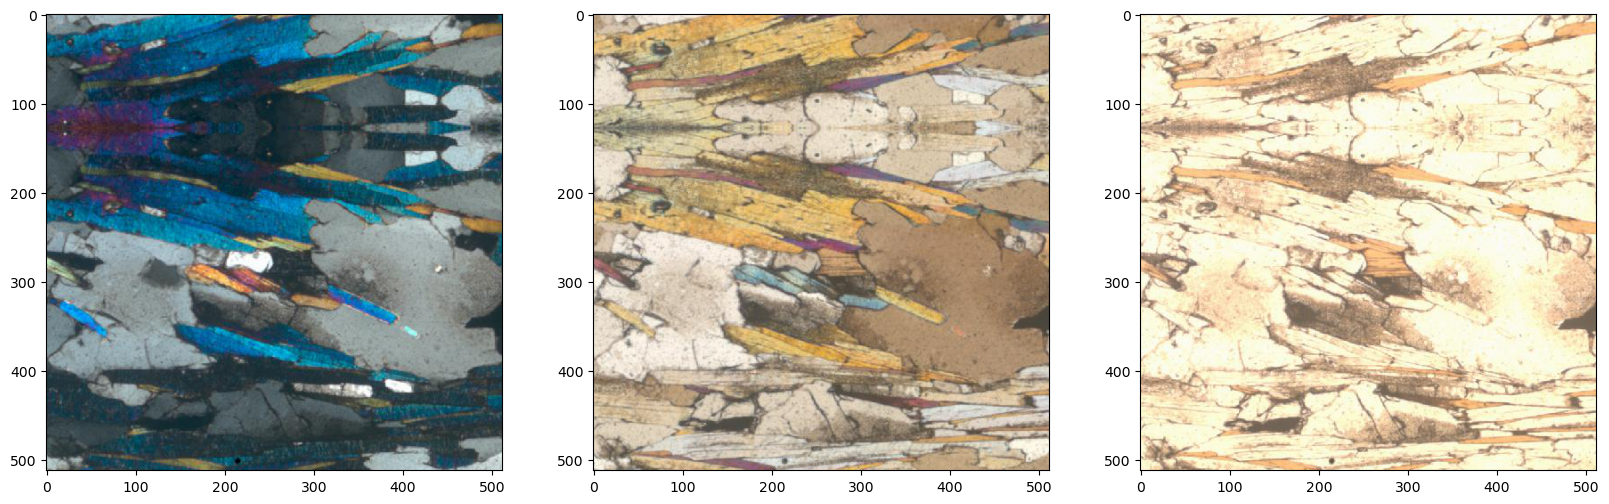

In [23]:
get_inputs(test_ds[0])

2


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

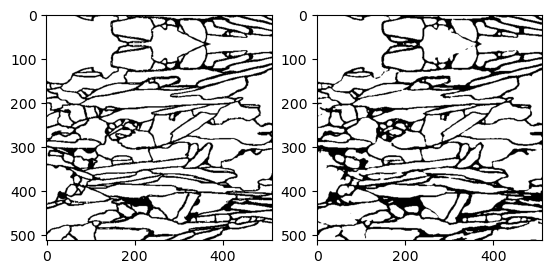

In [47]:
check_final(test_ds[25] , 0.75 , model)